In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.collections import PathCollection

from lab.third_party.li2018measuring import FEATURE_NAMES

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans-serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
def load_importances(protocols=("quic", "tcp"), names=None):
    return (pd.concat([
        pd.read_csv(f"../results/tree-importance/importances-{protocol}.csv", header=None, names=FEATURE_NAMES)
        for protocol in protocols
    ], keys=protocols, names=["protocol", "repetition"])
            .rename_axis("feature", axis=1)
            .stack()
            .rename("MDI")
            .reorder_levels([0, 2, 1]))

importances = load_importances()
importances

protocol  feature                                   repetition
quic      Packet Count::total pkt count             0             0.002436
          Packet Count::outgoing pkt count          0             0.001860
          Packet Count::incoming pkt count          0             0.002408
          Packet Count::outgoing count/total count  0             0.002592
          Packet Count::incoming count/total count  0             0.002696
                                                                    ...   
tcp       CUMUL::99                                 29            0.002518
          CUMUL::100                                29            0.002687
          CUMUL::101                                29            0.002449
          CUMUL::102                                29            0.002386
          CUMUL::103                                29            0.002706
Name: MDI, Length: 182580, dtype: float64

In [3]:
def rank_features(importances):
    return (importances
            .groupby(["protocol", "repetition"])
            .rank(ascending=False, method="average")
            .groupby(["protocol", "feature"])
            .mean()
            .rename("mean-rank"))
    
ranks = rank_features(importances)
ranks

protocol  feature                                 
quic      Packet Count::total pkt count                75.600000
          Packet Count::outgoing pkt count            124.533333
          Packet Count::incoming pkt count             66.800000
          Packet Count::outgoing count/total count     61.333333
          Packet Count::incoming count/total count     66.533333
                                                         ...    
tcp       CUMUL::99                                    85.233333
          CUMUL::100                                   79.666667
          CUMUL::101                                   80.600000
          CUMUL::102                                   79.300000
          CUMUL::103                                   70.633333
Name: mean-rank, Length: 6086, dtype: float64

In [4]:
ranks.filter(like="TRANS_", axis=0)

protocol  feature                                         
quic      Packet Ordering (TRANS_POSITION)::Outgoing::0       1320.600000
          Packet Ordering (TRANS_POSITION)::Outgoing::1        463.833333
          Packet Ordering (TRANS_POSITION)::Outgoing::2        148.100000
          Packet Ordering (TRANS_POSITION)::Outgoing::3        371.366667
          Packet Ordering (TRANS_POSITION)::Outgoing::4         86.566667
                                                                 ...     
tcp       Packet Ordering (TRANS_POSITION)::Incoming::297      463.766667
          Packet Ordering (TRANS_POSITION)::Incoming::298      464.366667
          Packet Ordering (TRANS_POSITION)::Incoming::299      457.933333
          Packet Ordering (TRANS_POSITION)::Incoming::std      159.533333
          Packet Ordering (TRANS_POSITION)::Incoming::mean     376.533333
Name: mean-rank, Length: 1208, dtype: float64

In [5]:
_Set2_data = (
    (0.4,                 0.76078431372549016, 0.6470588235294118 ),
    (0.9882352941176471,  0.55294117647058827, 0.3843137254901961 ),
    (0.55294117647058827, 0.62745098039215685, 0.79607843137254897),
    (0.90588235294117647, 0.54117647058823526, 0.76470588235294112),
    (0.65098039215686276, 0.84705882352941175, 0.32941176470588235),
    (1.0,                 0.85098039215686272, 0.18431372549019609),
    (0.89803921568627454, 0.7686274509803922,  0.58039215686274515),
    (0.70196078431372544, 0.70196078431372544, 0.70196078431372544),
    )

print([matplotlib.colors.to_hex(x).replace("#", "") for x in _Set2_data])

['66c2a5', 'fc8d62', '8da0cb', 'e78ac3', 'a6d854', 'ffd92f', 'e5c494', 'b3b3b3']


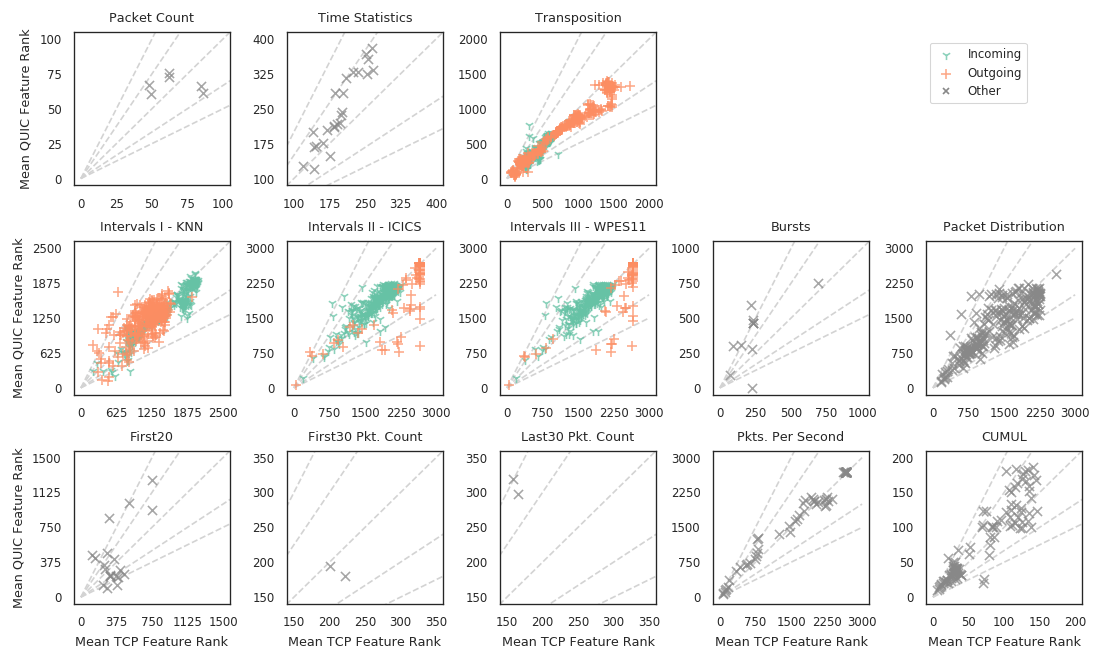

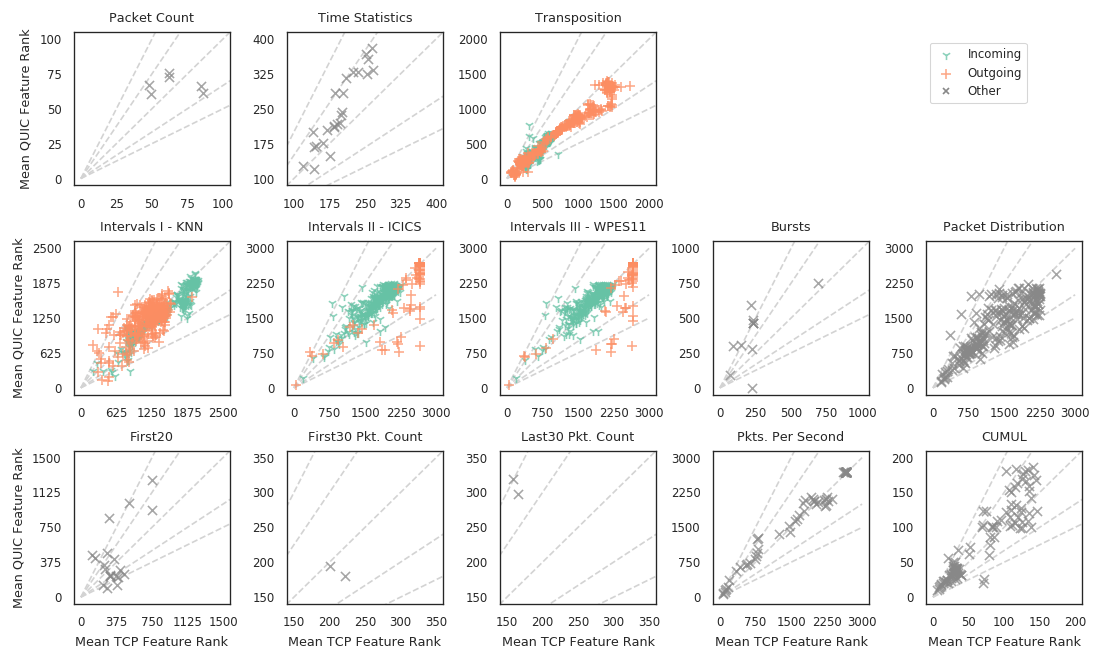

In [6]:
def _make_axes_square(axes, lower_lim=None, upper_lim=None):
    if lower_lim is None:
        lower_lim = min(axes.get_xlim()[0], axes.get_ylim()[0])
    if upper_lim is None:
        upper_lim = max(axes.get_xlim()[1], axes.get_ylim()[1])
    margin =  (upper_lim - lower_lim) * .05
    limits = (lower_lim, upper_lim)
    bounds = (lower_lim - margin, upper_lim + margin)
    
    # Update the limits to make the axes square
    axes.set_xlim(*bounds)
    axes.set_ylim(*bounds)
    
    # base = 500 if upper_lim >= 1500 else 100
    ticks = np.linspace(*limits, num=5, endpoint=True, dtype=int)
    # ticks = [base * np.ceil(x/base) for x in ticks]
    
    # Make the labels the same, so that the equivalence is confirmed visually
    # ticks = np.array(axes.get_xticks())
    # ticks = ticks[(ticks >= limits[0]) & (ticks <= limits[1])]
    axes.set_yticks(ticks)
    axes.set_xticks(ticks)
    

def _plot_equivalence_classes(axes):
    x_values = np.arange(0, 3000)
    for multiple in [0.5, 0.667, 1.0, 1.5, 2.0]:
        axes.plot(x_values, multiple * x_values, c="lightgrey", linewidth=1,
                  zorder=-1, linestyle="--")
        
    
def _plot(axes, data, title: str):
    assert np.array_equal(data.columns, ["quic", "tcp"])
    
    hues = ["C0", "C1", "C2", "#888888"]
    scatter_config = dict(marker="x", s=30, edgecolors="none", alpha=.75)
    
    if "Intervals" in title or title == "TRANS_POSITION":
        for substr, marker, hue in zip(["Incoming", "Outgoing"], ["1", "+"], hues[:2]):
            interval_data = data[data.index.str.contains(substr)]
            scatter_config["marker"] = marker
            axes.scatter(interval_data["tcp"], interval_data["quic"], label=substr, **scatter_config, c=hue)
    else:
        axes.scatter(data["tcp"], data["quic"], **scatter_config, c=hues[-1])
        
    _plot_equivalence_classes(axes)
    
    axes.set_title(TITLE_MAP.get(title, title))
    
    
GROUPS = [
    "Packet Count", "Time Statistics", "TRANS_POSITION", "NGRAM", 
    "Intervals (KNN)", "Intervals (ICICS)", "Intervals (WPES11)", "BURST", "Packet Distribution", 
    "FIRST20", "FIRST30_PKT_NUM", "LAST30_PKT_NUM", "PKT_PER_SECOND", "CUMUL"
]
TITLE_MAP = {
    "NGRAM": "Ngram", 
    "TRANS_POSITION": "Transposition",
    "Intervals (KNN)": "Intervals I - KNN",
    "Intervals (ICICS)": "Intervals II - ICICS",
    "Intervals (WPES11)": "Intervals III - WPES11",
    "BURST": "Bursts",
    "FIRST20": "First20",
    "FIRST30_PKT_NUM": "First30 Pkt. Count",
    "LAST30_PKT_NUM": "Last30 Pkt. Count",
    "PKT_PER_SECOND": "Pkts. Per Second"
}

    
def plot_ranks(ranks):
    ranks = ranks.unstack("protocol")
    
    figure, axes_matrix = plt.subplots(3, 5, figsize=(12 * 9/12, 7 * 9/12), dpi=120)
    figure.tight_layout(h_pad=2, w_pad=1)
    
    axes_list = axes_matrix.reshape((-1, ))
    
    # Signal where we want to skip an axes 
    groups = GROUPS[:]
    groups.insert(4, None)
    
    for i, (axes, tag) in enumerate(zip(axes_list, groups)):
        if tag in (None, "NGRAM"):
            axes.remove()
            continue
            
        _plot(axes, ranks.filter(like=tag, axis=0), title=tag)
        
        axes.set_ylabel("Mean QUIC Feature Rank" if i % 5 == 0 else "")
        axes.set_xlabel("Mean TCP Feature Rank" if i >= 10 else "")
        
    # Add the legend
    handles, labels = axes_matrix[1][2].get_legend_handles_labels()
    handles.append(matplotlib.lines.Line2D([], [], marker="x", linestyle="none", linewidth=1, label="Other", c="#888888"))
    labels.append("Other")
    axes_matrix[1][2].legend(handles, labels, loc=(2.75, 1.9))
        
    # Zoom as desired
    zoom_levels = [
        [(0, 100), (100, 400), (0, 2000), None, None],
        [(0, 2500), (0, 3000), (0, 3000), (0, 1000), (0, 3000)],
        [(0, 1500), (150, 350), (150, 350), (0, 3000), (0, 200)],
    ]
    
    for axis, limits in zip(np.ravel(axes_matrix), np.ravel(zoom_levels)):
        if limits is not None:
            _make_axes_square(axis, *limits)
    
    return figure
    
with plt.style.context(["mpl-style/white.mplstyle", "mpl-style/pets.mplstyle"]):
    figure = plot_ranks(ranks)
    for marker_collection in figure.findobj(PathCollection):
        if marker_collection.get_offsets().shape[0] > 30:
            marker_collection.set_rasterized(True)
    figure.savefig("../results/plots/feature-rank-comparison.pgf", dpi=150, bbox_inches="tight")
    display(figure)

In [7]:
# TODO: Complete after determining how many feature ranks we want to include
def select_differing_ranks(ranks):
    ranks = ranks.unstack("protocol")

    for group_tag in GROUPS:
        idx = ranks.filter(like=group_tag, axis=0).index
        ranks.loc[idx, "feature-group"] = group_tag
        
    ranks["ratio"] = ranks["quic"] / ranks["tcp"]
    ranks["valued-by"] = np.where(ranks["quic"] < ranks["tcp"], "quic", "tcp")
    ranks["ratio-max"] = np.maximum((ranks["quic"] / ranks["tcp"]).values, (ranks["tcp"] / ranks["quic"]).values)
    ranks = ranks[(ranks["ratio"] >= 1.5) | (ranks["ratio"] <= .667)]
    ranks = ranks[(ranks["quic"] <= 1000) | (ranks["tcp"] <= 1000)]
        
    return ranks.sort_values(by=["feature-group", "ratio-max"], ascending=False).set_index("feature-group", append=True)
    
differing = select_differing_ranks(ranks)#.groupby("feature-group").apply(lambda x: display(x))


for tag in GROUPS:
    try:
        idx = np.argsort(differing.index.get_level_values("feature").str.rsplit("::", n=1, expand=True).get_level_values(1).astype(int).values)
        display(differing.iloc[idx].xs(tag, level="feature-group"))
    except KeyError:
        print(f"Skipping {tag}")
        continue

Skipping Packet Count


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
Time Statistics::Outgoing: Trans. Statistics::1,284.366667,187.333333,1.517972,tcp,1.517972


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
Packet Ordering (TRANS_POSITION)::Incoming::2,354.000000,711.533333,0.497517,quic,2.009981
Packet Ordering (TRANS_POSITION)::Incoming::3,207.400000,315.300000,0.657786,quic,1.520251
Packet Ordering (TRANS_POSITION)::Outgoing::4,86.566667,231.700000,0.373615,quic,2.676550
Packet Ordering (TRANS_POSITION)::Incoming::4,772.666667,315.566667,2.448505,tcp,2.448505
Packet Ordering (TRANS_POSITION)::Outgoing::5,93.666667,299.500000,0.312743,quic,3.197509
Packet Ordering (TRANS_POSITION)::Incoming::6,578.333333,363.000000,1.593205,tcp,1.593205
Packet Ordering (TRANS_POSITION)::Incoming::7,615.566667,310.300000,1.983779,tcp,1.983779
Packet Ordering (TRANS_POSITION)::Incoming::8,401.033333,262.066667,1.530272,tcp,1.530272
Packet Ordering (TRANS_POSITION)::Incoming::9,430.500000,270.733333,1.590126,tcp,1.590126


Skipping NGRAM


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
Intervals (KNN)::Outgoing::2,467.100000,846.266667,0.551954,quic,1.811746
Intervals (KNN)::Incoming::3,501.266667,824.133333,0.608235,quic,1.644102
Intervals (KNN)::Incoming::4,219.666667,603.866667,0.363767,quic,2.749014
Intervals (KNN)::Outgoing::5,622.466667,319.600000,1.947643,tcp,1.947643
Intervals (KNN)::Incoming::5,286.166667,549.033333,0.521219,quic,1.918579
Intervals (KNN)::Incoming::6,450.933333,278.733333,1.617795,tcp,1.617795
Intervals (KNN)::Outgoing::6,397.133333,715.466667,0.555069,quic,1.801578
Intervals (KNN)::Outgoing::7,1051.966667,292.400000,3.597697,tcp,3.597697
Intervals (KNN)::Incoming::8,315.300000,531.366667,0.593376,quic,1.685273


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
Intervals (ICICS)::Outgoing::0,66.566667,40.900000,1.627547,tcp,1.627547
Intervals (ICICS)::Outgoing::1,680.966667,387.800000,1.755974,tcp,1.755974
Intervals (ICICS)::Outgoing::3,779.033333,349.433333,2.229419,tcp,2.229419
Intervals (ICICS)::Incoming::3,649.700000,410.000000,1.584634,tcp,1.584634
Intervals (ICICS)::Outgoing::12,994.766667,1823.600000,0.545496,quic,1.833194
Intervals (ICICS)::Outgoing::13,814.900000,1857.900000,0.438613,quic,2.279912
Intervals (ICICS)::Outgoing::14,820.866667,1931.100000,0.425077,quic,2.352514
Intervals (ICICS)::Outgoing::16,986.400000,2183.333333,0.451786,quic,2.213436
Intervals (ICICS)::Outgoing::17,778.500000,2214.033333,0.351621,quic,2.843973


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
Intervals (WPES11)::Outgoing::1,670.833333,387.233333,1.732375,tcp,1.732375
Intervals (WPES11)::Outgoing::3,685.866667,363.566667,1.886495,tcp,1.886495
Intervals (WPES11)::Incoming::3,605.100000,372.900000,1.622687,tcp,1.622687
Intervals (WPES11)::Outgoing::6,822.433333,1869.666667,0.439882,quic,2.273335
Intervals (WPES11)::Outgoing::8,933.866667,2213.566667,0.421883,quic,2.370324
Intervals (WPES11)::Outgoing::9,777.700000,2203.966667,0.352864,quic,2.833955
Intervals (WPES11)::Outgoing::10,933.766667,2201.733333,0.424105,quic,2.357905
Intervals (WPES11)::Incoming::27,1556.900000,805.600000,1.932597,tcp,1.932597
Intervals (WPES11)::Outgoing::31,898.700000,2643.883333,0.339917,quic,2.941898


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
BURST::(>5) + (>10) + (>15)::0,463.200000,230.700000,2.007802,tcp,2.007802
BURST::ave + ave + num::0,306.533333,147.400000,2.079602,tcp,2.079602
BURST::(>5) + (>10) + (>15)::1,462.233333,232.933333,1.984402,tcp,1.984402
BURST::ave + ave + num::2,482.400000,231.466667,2.084101,tcp,2.084101
BURST::(>5) + (>10) + (>15)::2,463.566667,231.966667,1.998419,tcp,1.998419
BURST::first 5 bursts::2,1.000000,225.033333,0.004444,quic,225.033333
BURST::first 5 bursts::3,301.500000,88.433333,3.409348,tcp,3.409348
BURST::first 5 bursts::4,595.966667,219.266667,2.717999,tcp,2.717999


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
Packet Distribution::Outgoing::7,689.666667,421.166667,1.637515,tcp,1.637515
Packet Distribution::alternative::13,1137.600000,351.566667,3.235802,tcp,3.235802
Packet Distribution::alternative::16,858.166667,1287.300000,0.666641,quic,1.500058
Packet Distribution::Outgoing::22,616.466667,993.366667,0.620583,quic,1.611387
Packet Distribution::Outgoing::30,845.233333,561.500000,1.505313,tcp,1.505313
Packet Distribution::Outgoing::68,1618.700000,914.866667,1.769329,tcp,1.769329
Packet Distribution::Outgoing::82,951.300000,1597.000000,0.595679,quic,1.678755
Packet Distribution::Outgoing::100,1423.800000,860.400000,1.654812,tcp,1.654812
Packet Distribution::Outgoing::104,985.000000,1685.200000,0.584500,quic,1.710863


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
FIRST20::0,1016.333333,503.300000,2.019339,tcp,2.019339
FIRST20::2,1264.400000,754.000000,1.676923,tcp,1.676923
FIRST20::3,848.200000,300.600000,2.821690,tcp,2.821690
FIRST20::4,456.133333,116.500000,3.915308,tcp,3.915308
FIRST20::5,422.133333,146.266667,2.886053,tcp,2.886053
FIRST20::7,470.266667,270.700000,1.737224,tcp,1.737224
FIRST20::8,248.366667,458.866667,0.541261,quic,1.847537
FIRST20::9,128.233333,376.733333,0.340382,quic,2.937874
FIRST20::11,103.233333,275.466667,0.374758,quic,2.668389


Skipping FIRST30_PKT_NUM


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
LAST30_PKT_NUM::0,297.433333,166.133333,1.790329,tcp,1.790329
LAST30_PKT_NUM::1,319.266667,158.066667,2.019823,tcp,2.019823


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
PKT_PER_SECOND::2,571.300000,334.700000,1.706902,tcp,1.706902
PKT_PER_SECOND::3,650.700000,427.700000,1.521394,tcp,1.521394
PKT_PER_SECOND::9,1239.866667,782.066667,1.585372,tcp,1.585372
PKT_PER_SECOND::10,1280.166667,799.400000,1.601409,tcp,1.601409
PKT_PER_SECOND::103,361.100000,191.600000,1.884656,tcp,1.884656


protocol,quic,tcp,ratio,valued-by,ratio-max
feature,,,,,
CUMUL::2,25.466667,71.300000,0.357176,quic,2.799738
CUMUL::3,10.833333,6.233333,1.737968,tcp,1.737968
CUMUL::6,67.133333,34.600000,1.940270,tcp,1.940270
CUMUL::7,56.500000,20.833333,2.712000,tcp,2.712000
CUMUL::8,49.700000,27.833333,1.785629,tcp,1.785629
CUMUL::9,50.600000,31.233333,1.620064,tcp,1.620064
CUMUL::24,43.933333,28.800000,1.525463,tcp,1.525463
CUMUL::44,23.133333,14.966667,1.545657,tcp,1.545657
CUMUL::47,19.366667,11.500000,1.684058,tcp,1.684058


In [8]:
def make_table(ranks, cutoff: int = 50):
    
    ranks = ranks.unstack("protocol")
    ranks = pd.concat([
        ranks[(ranks["quic"] <= cutoff) & (ranks["tcp"] > cutoff)],
        ranks[(ranks["tcp"] <= cutoff) & (ranks["quic"] > cutoff)]
    ])
    ranks["diff"] = ranks["quic"] - ranks["tcp"]
    ranks["absdiff"] = np.abs(ranks["diff"])

    return ranks.sort_values("absdiff", ascending=False).drop(columns="absdiff").astype(int)

table = make_table(ranks, 100)
display(table)

print(table.to_latex())

protocol,quic,tcp,diff
feature,,,
BURST::first 5 bursts::2,1,225,-224
BURST::first 5 bursts::3,301,88,213
Packet Ordering (TRANS_POSITION)::Outgoing::5,93,299,-205
Packet Ordering (TRANS_POSITION)::Outgoing::4,86,231,-145
Packet Ordering (TRANS_POSITION)::Outgoing::19,27,114,-86
Packet Ordering (TRANS_POSITION)::Outgoing::18,40,119,-78
Packet Ordering (TRANS_POSITION)::Outgoing::20,51,125,-73
Packet Ordering (TRANS_POSITION)::Outgoing::14,60,125,-64
Packet Ordering (TRANS_POSITION)::Outgoing::13,68,130,-61


\begin{tabular}{lrrr}
\toprule
protocol &  quic &  tcp &  diff \\
feature                                        &       &      &       \\
\midrule
BURST::first 5 bursts::2                       &     1 &  225 &  -224 \\
BURST::first 5 bursts::3                       &   301 &   88 &   213 \\
Packet Ordering (TRANS\_POSITION)::Outgoing::5  &    93 &  299 &  -205 \\
Packet Ordering (TRANS\_POSITION)::Outgoing::4  &    86 &  231 &  -145 \\
Packet Ordering (TRANS\_POSITION)::Outgoing::19 &    27 &  114 &   -86 \\
Packet Ordering (TRANS\_POSITION)::Outgoing::18 &    40 &  119 &   -78 \\
Packet Ordering (TRANS\_POSITION)::Outgoing::20 &    51 &  125 &   -73 \\
Packet Ordering (TRANS\_POSITION)::Outgoing::14 &    60 &  125 &   -64 \\
Packet Ordering (TRANS\_POSITION)::Outgoing::13 &    68 &  130 &   -61 \\
Packet Ordering (TRANS\_POSITION)::Outgoing::22 &    83 &  142 &   -59 \\
Packet Ordering (TRANS\_POSITION)::Outgoing::12 &    58 &  117 &   -58 \\
Packet Ordering (TRANS\_POSITION)::Outgo

In [9]:
temp = ranks.loc["quic"].sort_values().reset_index()
temp

,feature,mean-rank
0,BURST::first 5 bursts::2,1.000000
1,CUMUL::3,10.833333
2,CUMUL::53,12.033333
3,CUMUL::52,14.233333
4,CUMUL::51,16.066667
...,...,...
3038,Intervals (WPES11)::Outgoing::193,2688.633333
3039,Intervals (WPES11)::Outgoing::194,2688.633333
3040,Intervals (WPES11)::Outgoing::195,2688.633333
3041,Intervals (WPES11)::Outgoing::184,2688.633333


In [10]:
[FEATURE_NAMES.index(feat) for feat in temp["feature"]]

[2786,
 2942,
 2992,
 2991,
 2990,
 2989,
 2986,
 3042,
 2982,
 2987,
 2985,
 2980,
 2983,
 2988,
 2981,
 2984,
 2941,
 2956,
 2978,
 2954,
 180,
 2976,
 2974,
 2958,
 2979,
 2967,
 2959,
 2977,
 2952,
 2975,
 2950,
 2957,
 2969,
 2970,
 2955,
 2953,
 2951,
 2966,
 2971,
 2965,
 2949,
 179,
 2973,
 2964,
 2962,
 2961,
 2972,
 2968,
 2963,
 172,
 2960,
 177,
 2947,
 2948,
 181,
 178,
 2260,
 176,
 2946,
 173,
 3041,
 12,
 175,
 2939,
 3,
 4,
 1666,
 2,
 2945,
 174,
 49,
 65,
 2938,
 37,
 41,
 182,
 97,
 2944,
 10,
 3040,
 0,
 2913,
 169,
 461,
 183,
 3039,
 3038,
 165,
 462,
 2785,
 171,
 166,
 3020,
 3018,
 2813,
 3017,
 2997,
 3036,
 3034,
 3037,
 3021,
 3035,
 2996,
 2800,
 3022,
 170,
 184,
 168,
 3023,
 3019,
 3016,
 3033,
 3032,
 3024,
 3030,
 167,
 7,
 17,
 3015,
 3031,
 3025,
 5,
 1079,
 2940,
 2994,
 2995,
 1,
 3029,
 11,
 13,
 2798,
 3027,
 481,
 3026,
 185,
 3028,
 2801,
 2777,
 2754,
 482,
 1083,
 3014,
 2918,
 19,
 163,
 2999,
 3013,
 3000,
 186,
 2998,
 3012,
 3006,
 3005,

# Which features should be used for QUIC

In [11]:
columns = (ranks.loc["quic"].sort_values().reset_index()
 .rename({"mean-rank": "rank"}, axis=1))
columns = columns.assign(index=[FEATURE_NAMES.index(name) for name in columns["feature"]])
columns

,feature,rank,index
0,BURST::first 5 bursts::2,1.000000,2786
1,CUMUL::3,10.833333,2942
2,CUMUL::53,12.033333,2992
3,CUMUL::52,14.233333,2991
4,CUMUL::51,16.066667,2990
...,...,...,...
3038,Intervals (WPES11)::Outgoing::193,2688.633333,2453
3039,Intervals (WPES11)::Outgoing::194,2688.633333,2454
3040,Intervals (WPES11)::Outgoing::195,2688.633333,2455
3041,Intervals (WPES11)::Outgoing::184,2688.633333,2444


In [12]:
# Note: This uses the average rank instead of ranking average MDI (original). The results will differ from the provided datafile
# But should be roughly equivalent.
columns.to_csv("../results/tree-importance/quic-feature-ranks.csv", header=True, index=False)